<a href="https://colab.research.google.com/github/barbaroja2000/imagery/blob/main/Deep_Floyd_Text_Generation_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Floyd - Text Generation Experiments

* Runs on google free tier (T4) via cpu offloading
* It is ... slow - (6-8 minutes e2e generation). Down to CPU offloading & pipe deletion, If your running on a decent GPU you should comment this out
* Deep Floyd requires model signup/T&C . Requires API token in HF call
* Model card https://huggingface.co/DeepFloyd/IF-I-XL-v1.0
* Instructions on running on low GPU memory -  https://huggingface.co/docs/diffusers/main/en/api/pipelines/if
* Other ref:
  * https://github.com/deep-floyd/IF
  * https://www.deepfloyd.ai/deepfloyd-if
  * https://stablediffusionweb.com/prompts

## Observations
* Repeat the text you want to print multiple times in the prompt for best results

In [1]:
!pip install -qU diffusers accelerate transformers safetensors sentencepiece accelerate bitsandbytes


In [3]:
#@title Load Keys
#@markdown Utitily to load keys from fs, replace with environ vars if not using
!python -m pip install python-dotenv
import os

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import dotenv
dotenv.load_dotenv('/content/drive/MyDrive/keys/keys.env')

Mounted at /content/drive/


True

In [4]:
HUGGINGFACEHUB_API_TOKEN=os.environ.get("HUGGINGFACEHUB_API_TOKEN")

In [9]:
#@title Imports
from diffusers import IFPipeline, IFSuperResolutionPipeline,DiffusionPipeline
import torch
import gc
from transformers import T5EncoderModel
from diffusers.utils import pt_to_pil
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
#@title Prompts
NEGATIVE_PROMPT="""(((out of frame))), blurry, watermark, watermarked, cropped, out of frame, worst quality, low quality, jpeg artifacts, poorly lit, glitch, error, out of focus"""

In [6]:
prompt = 'vector drawing cartoon graffiti style  text "Paddy time"  on a black background with no texture.  pub design, pro vector, irish style, full design, 6 colors only, solid colors, no shadows, full design, warm colors, sticker with text "Paddy time", bright colors'
#prompt='aztec style  text "Montezumas Revenge"  on a black background.  pro vector, full design, 6 colors only, solid colors, shadows, hot colors, sticker, bright colors'

In [7]:
prompt = 'wildstyle graffiti  text "TIKI TIKI"  on a black background.  6 colors only, solid colors, no shadows, full design, hot colors, sticker, bright colors   spray paint text "TIKI TIKI" '
#prompt = 'neon sign text "Miami Heat" black background no texture.  photorealistic purple teal blue white pink orange color neon sign "Miami Heat"'

In [8]:
prompt ='Hawaii style text "Tiki Tiki" on a black background. Halau style font graphic woodcut embossed sticker. Three colours only moody. text "Tiki Tiki"'

In [10]:
#@title Class : Utility methods for displaying generated output + 3 stage pass & embeddings
class DeepFloydIF:
    def __init__(self, huggingfacehub_api_token, negative_prompt):
        self.huggingfacehub_api_token = huggingfacehub_api_token
        self.negative_prompt = negative_prompt
        self.prompt_embeds = None
        self.negative_embeds = None
        self.num_images_per_prompt = None
        self.preview_images = None
        self.generator=torch.Generator().manual_seed(0)
        self.prompt = None

    def create_embedding(self, prompt):
        pipe = DiffusionPipeline.from_pretrained(
            "DeepFloyd/IF-I-XL-v1.0",
            variant="fp16",
            torch_dtype=torch.float16,
            use_auth_token=self.huggingfacehub_api_token
        )
        pipe.enable_model_cpu_offload()

        self.prompt_embeds, self.negative_embeds = pipe.encode_prompt(prompt, self.negative_prompt)
        self.prompt=prompt

        del pipe
        gc.collect()
        torch.cuda.empty_cache()

    def create_versions(self, num_images_per_prompt):
        pipe = IFPipeline.from_pretrained(
        "DeepFloyd/IF-I-XL-v1.0",
        text_encoder=None,
        variant="fp16",
        torch_dtype=torch.float16,
        device_map="auto",
        use_auth_token=self.huggingfacehub_api_token
    )
        pipe.enable_model_cpu_offload()

        self.preview_images = pipe(
            prompt_embeds=self.prompt_embeds,
            negative_prompt_embeds=self.negative_embeds,
            num_images_per_prompt=num_images_per_prompt,
             generator=self.generator,
            output_type="pt",
        ).images

        # Remove the pipeline so we can load the super-resolution pipeline
        del pipe
        gc.collect()
        torch.cuda.empty_cache()

    def display_preview(self):
        num_images_per_prompt = len(pt_to_pil(self.preview_images))
        if num_images_per_prompt <= 4:
            num_rows = 1
            num_cols = num_images_per_prompt
        else:
            num_rows = int(num_images_per_prompt**0.5)
            num_cols = num_images_per_prompt // num_rows + (1 if num_images_per_prompt % num_rows > 0 else 0)
            if num_rows * num_cols < num_images_per_prompt:
                num_rows += 1

        # Create a figure and axis
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
        axes = axes.flatten() if num_rows * num_cols > 1 else [axes]

        # Iterate through the images
        for indx in range(num_images_per_prompt):
            pil_image = pt_to_pil(self.preview_images)[indx]

            # Display the image
            axes[indx].imshow(pil_image)
            axes[indx].axis('off')  # To hide axes

        plt.tight_layout()
        plt.show()

    def super_resolution(self, preview_image_index):

        pipe = IFSuperResolutionPipeline.from_pretrained(
            "DeepFloyd/IF-II-L-v1.0",
            text_encoder=None,
            variant="fp16",
            torch_dtype=torch.float16,
            device_map="auto",
            use_auth_token=self.huggingfacehub_api_token
        )

        pipe.enable_model_cpu_offload()

        self.image = pipe(
            image=pt_to_pil(self.preview_images)[preview_image_index],
            prompt_embeds=self.prompt_embeds,
            negative_prompt_embeds=self.negative_embeds,
            output_type="pt",
            generator=self.generator,
        ).images

        pt_to_pil(self.image)[0].save("./if_stage_II.png")

        # Remove the pipeline so we can load the super-resolution pipeline
        del pipe
        gc.collect()
        torch.cuda.empty_cache()

    def final_resolution(self):

        super_res_2_pipe = DiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-x4-upscaler", torch_dtype=torch.float16
        )
        super_res_2_pipe.enable_model_cpu_offload()

        self.final_image = super_res_2_pipe(
            prompt=self.prompt,
            image=self.image,
            generator=self.generator,
            noise_level=100).images[0]

        # Remove the pipeline so we can load the super-resolution pipeline
        del super_res_2_pipe
        gc.collect()
        torch.cuda.empty_cache()

    def print_final(self):
        # Create a Matplotlib figure
        plt.figure(figsize=(5, 5))

        # Display the PIL image
        plt.imshow(self.final_image)

        # Hide the axes
        plt.axis('off')

        # Show the plot
        plt.show()

    def final_save(self, path):
        self.final_image.save(path)

In [11]:
#@title Init class + create embeddings
deep_floyd_if = DeepFloydIF(huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN, negative_prompt=NEGATIVE_PROMPT)
deep_floyd_if.create_embedding(prompt=prompt)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00002-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of T5EncoderModel were not initialized from the model checkpoint at /root/.cache/huggingface/hub/models--DeepFloyd--IF-I-XL-v1.0/snapshots/c03d510e9b75bce9f9db5bb85148c1402ad7e694/text_encoder and are newly initialized: ['encoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [12]:
#@title Init class + create initatial previews
deep_floyd_if.create_versions(num_images_per_prompt=8)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00002-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

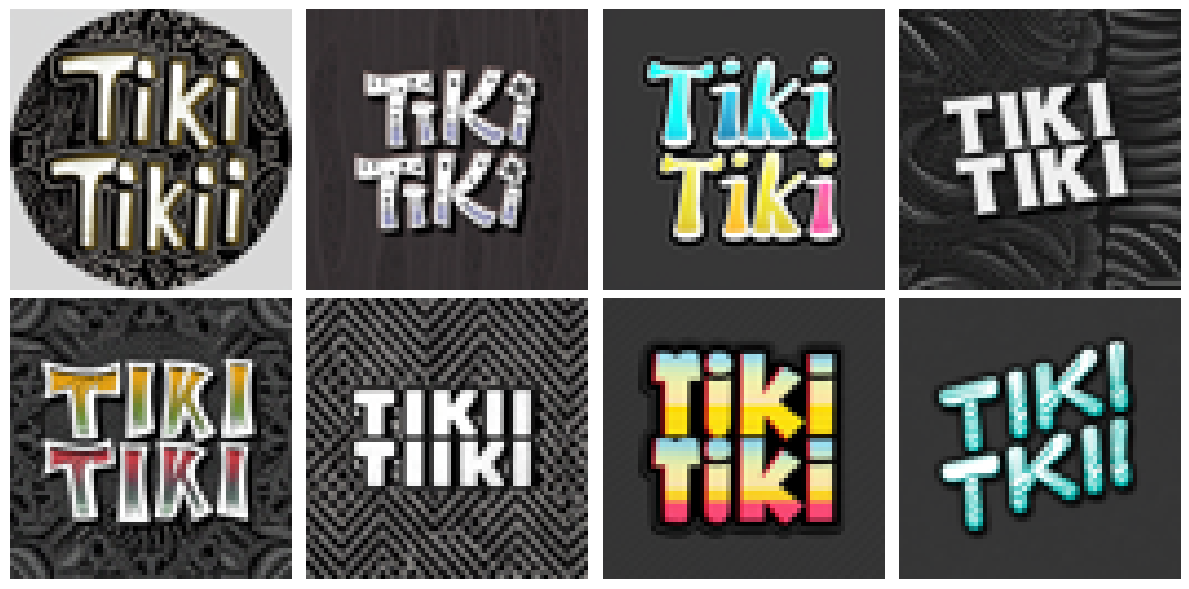

In [13]:
#@title Display previews
deep_floyd_if.display_preview()

In [18]:
#@title  Pick the index of the cell you want to upscale
deep_floyd_if.super_resolution(4)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00002-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
#@title  Final Upscale
deep_floyd_if.final_resolution()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

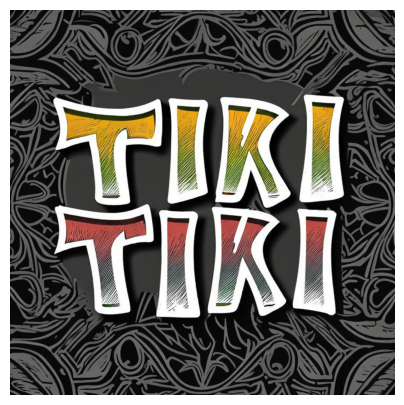

In [20]:
deep_floyd_if.print_final()

In [17]:
deep_floyd_if.final_save("./wiki.png")